# 📊 Projeto de Previsão de Churn - Telecom
**Disciplina:** Redes Neurais | **Aluno:** Douglas Carvalho

---

### 🎯 Objetivo
Desenvolver e avaliar um classificador baseado em **Stochastic Transformer (STab)** para prever o cancelamento de clientes (Churn), focando em estabilidade e robustez em dados tabulares.

### 🛠 Metodologia
Seguindo as diretrizes do projeto, a abordagem consiste em:
1.  **Setup do Ambiente:** Configuração e carregamento dos dados processados.
2.  **Modelagem STab:** Utilização de arquitetura Transformer estocástica.
3.  **Avaliação:** Métricas completas (KS, AUROC, F1) e validação de estabilidade.
4.  **Registro:** Salvamento automático de logs e gráficos de performance.

# ==========================================
# 0. Imports & Instalação
# ==========================================

In [1]:
%%capture
!pip install -q xgboost pykan

import sys
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import kagglehub
import shutil
import json

# Configuração de Plots
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# 1. Setup do Ambiente
# ==========================================

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Adicionar diretório atual ao path para importações funcionarem

In [3]:
import sys
import os

sys.path.append('.')

Correção para Auto-Reload no Python 3.12 (Google Colab)

In [4]:
import importlib

if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

%load_ext autoreload
%autoreload 2

# ==========================================
# 2. Github
# ==========================================

In [5]:
# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/tabpfn-stab-tabkan

Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 265 (delta 28), reused 32 (delta 15), pack-reused 206 (from 1)
Receiving objects: 100% (265/265), 6.75 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/telecom-churn-project
Branch 'feature/tabpfn-stab-tabkan' set up to track remote branch 'feature/tabpfn-stab-tabkan' from 'origin'.
Switched to a new branch 'feature/tabpfn-stab-tabkan'


In [43]:

# 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
# !git fetch --all

# 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
# !git reset --hard origin/feature/tabpfn-stab-tabkan_final

Fetching origin
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 309 bytes | 309.00 KiB/s, done.
From https://github.com/vggd18/telecom-churn-project
 * [new branch]      feature/tabpfn-stab-tabkan_final -> origin/feature/tabpfn-stab-tabkan_final
HEAD is now at c09fd0e feat: remove arquivos de resultados obsoletos do projeto


Importar as ferramentas para resultados

In [16]:
from src.utils import ensure_directories, get_timestamped_path, log_experiment

ensure_directories()
print("✅ Diretórios de resultados verificados/criados.")

✅ Diretórios de resultados verificados/criados.


Caso você receba um erro de autenticação ao tentar o `git push`, pode ser necessário configurar suas credenciais do Git no Colab. Geralmente, o Colab pedirá para você fazer login no GitHub ou usar um Personal Access Token (PAT). Para mais informações sobre como configurar o PAT, você pode consultar a documentação do GitHub.

# ==========================================
# 3. Dados
# ==========================================

In [17]:
print("⬇️ Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"

dest_path = os.path.join(dest_dir, dest_file)

os.makedirs(dest_dir, exist_ok=True)

source_file = os.path.join(path, "customer_churn_telecom_services.csv")

if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...


100%|██████████| 112k/112k [00:00<00:00, 46.1MB/s]

📂 Dataset baixado em: /root/.cache/kagglehub/datasets/kapturovalexander/customers-churned-in-telecom-services/versions/3
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


Executar Pipeline de Dados

In [18]:
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [19]:

from models.stab_model import STabModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando STabModel (tuned + debug)...
========== STabModel INIT ==========
Device: cpu
Config efetivo:
  d_model=64, depth=4, n_heads=4, ff_mult=4
  ff_dropout=0.2, attn_dropout=0.1 (nota: não separado no layer)
  lr=0.0003, weight_decay=0.0, pooling=mean
  batch_size=256, epochs=40, max_fail=10

[build] input_dim registrado = 30
========== TRAIN START ==========
epochs=40, batch_size=256, max_fail=10
n_train=5162, n_val=2580
X_train dtype=torch.float32, y_train dtype=torch.float32
X_val device=cpu, y_val device=cpu
num_batches/epoch=21

[epoch 1] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.unsqueeze(-1): (256, 30, 1)
  feature_embed: (256, 30, 64)
  transformer out: (256, 30, 64)
  pooling 'mean': (256, 64)
  logits: (256,)
[epoch 1][batch 10/21] loss=0.684369 lr=0.0003
[epoch 1][batch 20/21] loss=0.670009 lr=0.0003
[epoch 1/40] train_loss=0.687996 val_loss=0.663305 best_val=0.663305 fails=0/10 lr=0.0003 time=17.5s
[epoch 2] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.uns

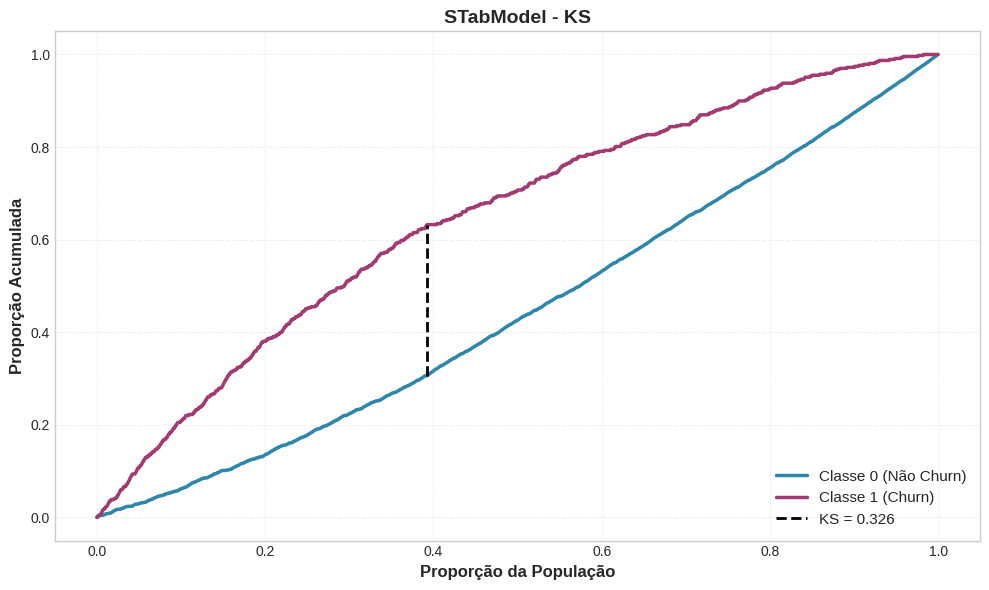

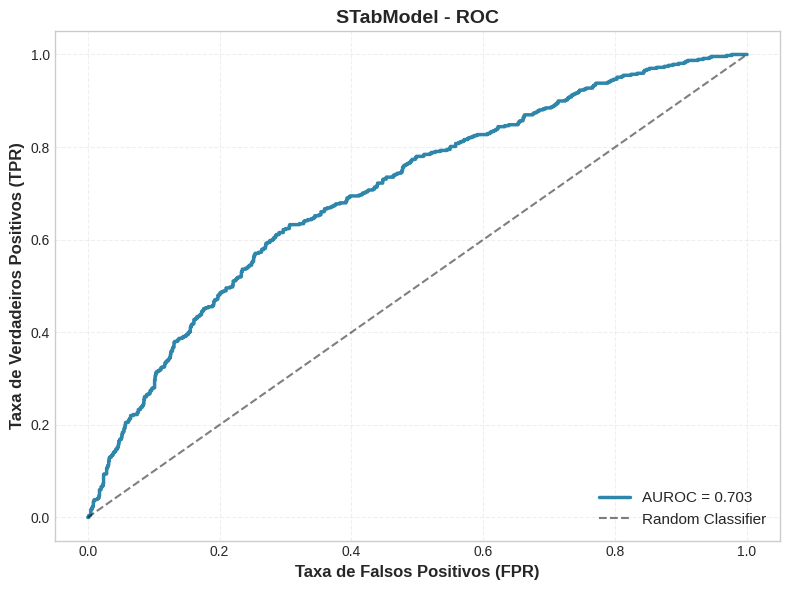

In [20]:
print("🚀 Treinando STabModel (tuned + debug)...")

stab_config = {
    "d_model": 64,
    "depth": 4,
    "n_heads": 4,
    "ff_mult": 4,
    "ff_dropout": 0.2,
    "lr": 3e-4,
    "batch_size": 256,
    "epochs": 40,
    "max_fail": 10,
    "pooling": "mean",

    # DEBUG
    "verbose": True,
    "log_every": 10,        # print a cada 10 batches
    "debug_shapes": True,   # imprime shapes internos (1º batch por época)
    "debug_grads": False    # ativa norma do gradiente (deixa False pra não poluir/atrasar)
}

stab = STabModel(config=stab_config)
stab.build(input_dim=X_train.shape[1])

stab.train(X_train, y_train, X_val, y_val)

y_pred_stab = stab.predict_proba(X_test)
metrics_stab = calculate_all_metrics(y_test, y_pred_stab)

print_metrics("STabModel (Teste)", metrics_stab)
plot_ks_statistic(y_test, y_pred_stab, title="STabModel - KS")
plot_roc_curve(y_test, y_pred_stab, title="STabModel - ROC")


📊 Calculando métricas...

🏆 RESULTADOS FINAIS (Teste):
   KS:       0.3260
   AUROC:    0.7028
   F1 Score: 0.4907
📊 Dashboard salvo em: results/figures/dashboard_final_stab_20260110_171122.png


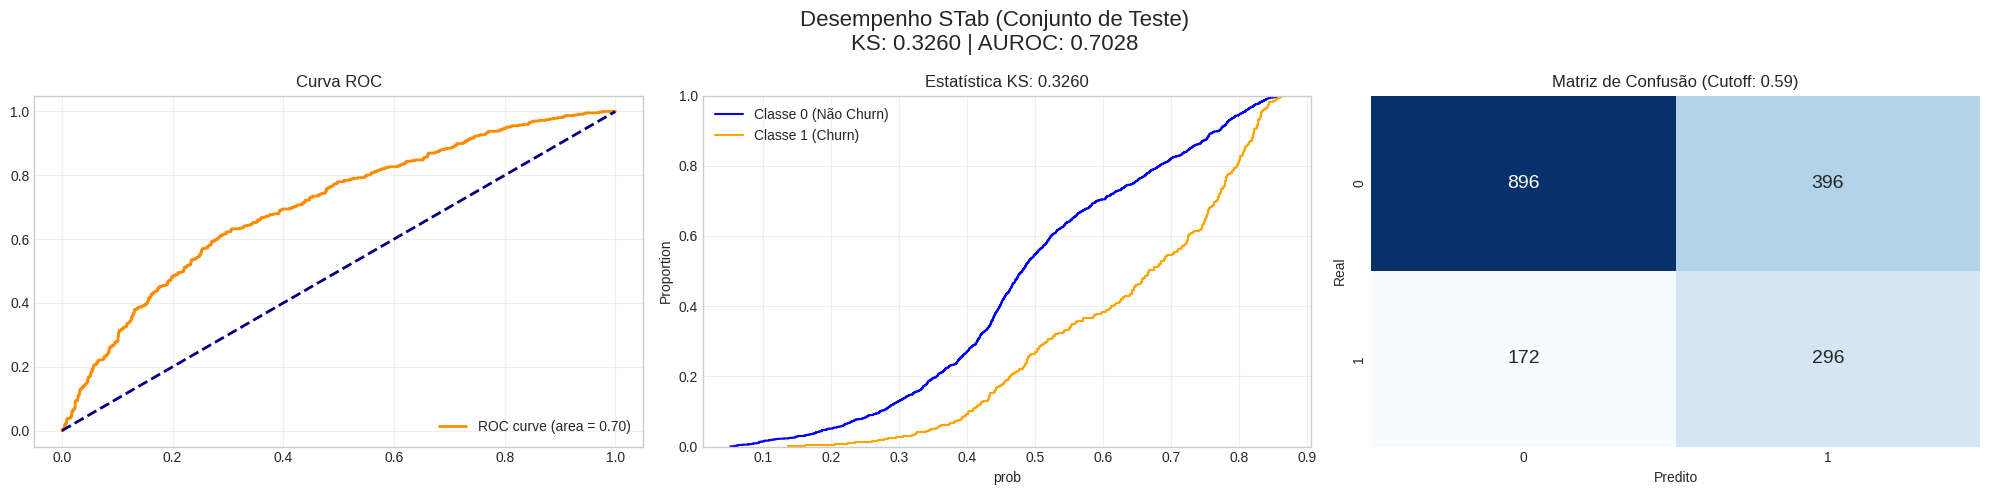

<Figure size 640x480 with 0 Axes>

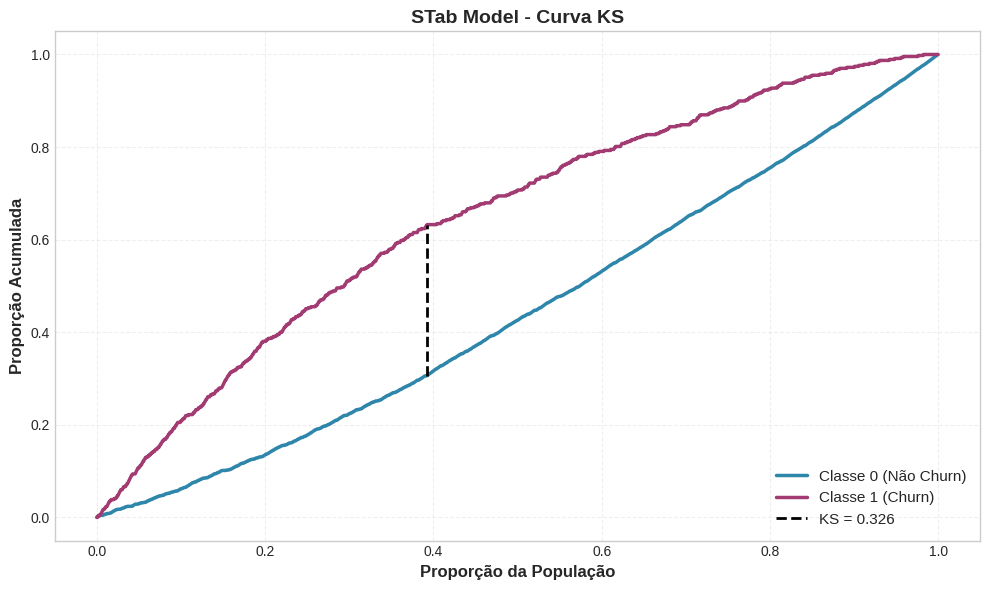

📉 Gráfico KS salvo em: results/figures/stab_ks_20260110_171123.png


<Figure size 640x480 with 0 Axes>

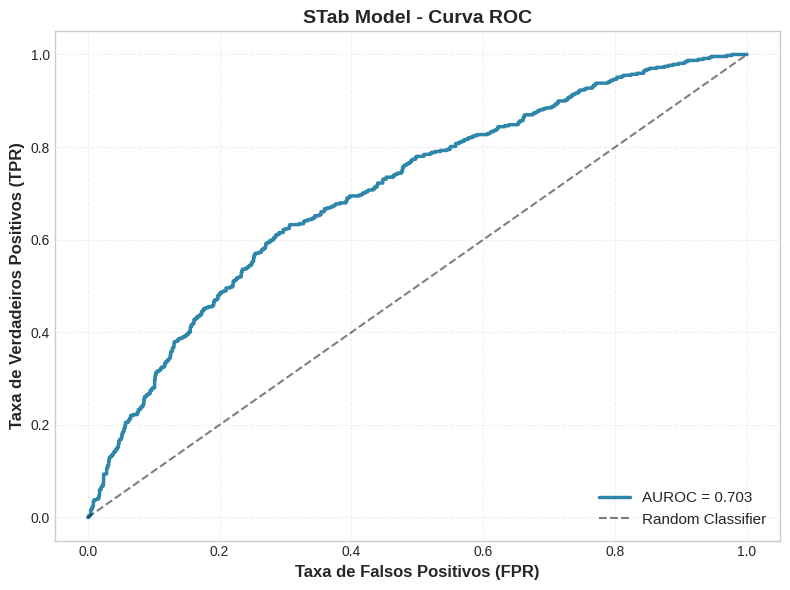

📉 Gráfico ROC salvo em: results/figures/stab_roc_20260110_171123.png

💾 Modelo salvo em: results/models/stab_model_final_20260110_171123.pkl
✅ Experimento registrado no CSV log.


In [26]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ---------------------------------------------------------
# 1. Previsão e Cálculo de Métricas
# ---------------------------------------------------------
print("📊 Calculando métricas...")
y_pred_test = stab.predict_proba(X_test)

# Tratamento para garantir array 1D
if y_pred_test.ndim > 1 and y_pred_test.shape[1] > 1:
    y_pred_test = y_pred_test[:, 1]

metrics_test = calculate_all_metrics(y_test, y_pred_test)

print(f"\n🏆 RESULTADOS FINAIS (Teste):")
print(f"   KS:       {metrics_test['ks']:.4f}")
print(f"   AUROC:    {metrics_test['auroc']:.4f}")
print(f"   F1 Score: {metrics_test['f1']:.4f}")


# ---------------------------------------------------------
# 2. Gerar e Salvar Dashboard (Resumo Visual)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle(f'Desempenho STab (Conjunto de Teste)\nKS: {metrics_test["ks"]:.4f} | AUROC: {metrics_test["auroc"]:.4f}', fontsize=16)

# --- Curva ROC (Subplot 1) ---
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Curva ROC')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# --- Curva KS (Subplot 2) ---
data_plot = pd.DataFrame({'prob': y_pred_test, 'target': y_test})
sns.ecdfplot(data=data_plot[data_plot.target==0], x='prob', ax=axes[1], label='Classe 0 (Não Churn)', color='blue')
sns.ecdfplot(data=data_plot[data_plot.target==1], x='prob', ax=axes[1], label='Classe 1 (Churn)', color='orange')
axes[1].set_title(f'Estatística KS: {metrics_test["ks"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# --- Matriz de Confusão (Subplot 3) ---
y_pred_class = (y_pred_test >= metrics_test.get('ks_threshold', 0.5)).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False, annot_kws={"size": 14})
axes[2].set_title(f'Matriz de Confusão (Cutoff: {metrics_test.get("ks_threshold", 0.5):.2f})')
axes[2].set_xlabel('Predito')
axes[2].set_ylabel('Real')

plt.tight_layout()

# Salvar Dashboard
dashboard_path = get_timestamped_path("dashboard_final_stab.png", subfolder="figures")
plt.savefig(dashboard_path)
print(f"📊 Dashboard salvo em: {dashboard_path}")
plt.show()


# ---------------------------------------------------------
# 3. Salvar Gráficos Individuais (Padrão MLP)
# ---------------------------------------------------------

# Gráfico KS Individual
plt.figure()
plot_ks_statistic(y_test, y_pred_test, title="STab Model - Curva KS")
ks_path = get_timestamped_path("stab_ks.png", subfolder="figures")
plt.savefig(ks_path)
plt.close() # Fecha para não duplicar output
print(f"📉 Gráfico KS salvo em: {ks_path}")

# Gráfico ROC Individual
plt.figure()
plot_roc_curve(y_test, y_pred_test, title="STab Model - Curva ROC")
roc_path = get_timestamped_path("stab_roc.png", subfolder="figures")
plt.savefig(roc_path)
plt.close()
print(f"📉 Gráfico ROC salvo em: {roc_path}")


# ---------------------------------------------------------
# 4. Salvar Modelo e Registrar Experimento
# ---------------------------------------------------------

# A. Salvar Modelo (.pkl)
# Verifica se a classe tem método save(), caso contrário usa joblib direto como fallback
try:
    model_path = get_timestamped_path("stab_model_final.pkl", subfolder="models")
    if hasattr(stab, 'save'):
        stab.save(model_path)
    else:
        # Fallback caso sua classe STab não tenha wrapper de save
        import joblib
        joblib.dump(stab, model_path)
    print(f"\n💾 Modelo salvo em: {model_path}")
except Exception as e:
    print(f"⚠️ Erro ao salvar modelo: {e}")

# B. Registrar no Log de Experimentos (CSV)
log_experiment(
    log_file='results/experiments_log.csv',
    model_name='STab_Final',
    metrics=metrics_test,
    params=stab_config
)
print("✅ Experimento registrado no CSV log.")